In [1]:
#from dataset import hippunfold_dataset
#from plotting import plot_gifti
import nibabel as nib
import numpy as np
import pandas as pd
import os
from glob import glob


import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from brainspace.mesh.mesh_io import read_surface
from brainspace.utils.parcellation import reduce_by_labels
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect

### plotting functions here for ease of editing:

In [2]:
from mpl_toolkits.mplot3d import art3d  # noqa: F401 unused import

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale.  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().'''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    return ax


def cdata_vertex_to_face(c,faces):
    '''Interpolates vertex data to the nearest face
    Input
      c: vertex data
      faces: face data'''
    
    cf = np.zeros(len(faces))
    for f in range(len(faces)):
        cf[f] = np.mean(c[faces[f]])
    return cf



def surfplot_cdata(ax,cdata,f,v,cwindow=False):
    '''create surface in existing axis
    Input
      ax: axis (of type subplot_kw={'projection': "3d"})
      cdata: color of surface
      f: faces
      v: vertices
      window cdata [True,False, or Tuple for custom window]'''
    cdata = cdata_vertex_to_face(cdata,f)
    # make window if needed
    if type(cwindow) == type(True):
        if not cwindow:
            norm = plt.Normalize(np.min(cdata), np.max(cdata)) 
            colors = plt.cm.viridis(norm(cdata))
        elif cwindow: # use default
            norm = plt.Normalize(window_cdata(cdata)[0],window_cdata(cdata)[1]) 
            colors = plt.cm.viridis(norm(cdata))
    else: # hard set window
        norm = plt.Normalize(cwindow[0],cwindow[1]) 
        colors = plt.cm.viridis(norm(cdata))

    pc = art3d.Poly3DCollection(v[f], facecolors=colors)
    ax.add_collection(pc)

    ax.set_xlim([np.min(v[:,0]),np.max(v[:,0])])
    ax.set_ylim([np.min(v[:,1]),np.max(v[:,1])])
    ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])
    ax.view_init(elev=90, azim=-90)
    ax = set_axes_equal(ax)
    ax.set_axis_off()
    return ax



def plot_gifti(gii,map,window=False):
    ''' plots a gifti structure. 
    Inputs
      gii: gfiti object as loaded by nibabel
      map: colour data [default all 1s]
      window: percentile to window colour axis around'''
    vertices = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
    faces = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(36,12), subplot_kw={'projection': "3d"})
    surfplot_cdata(axes,map,faces,vertices,window) 
    return fig, axes


## Read TSV file

In [3]:
tsv_path = 'Neuropsych_subjects_hippunfold_volumes_FULLMrtrix_Shahryar_03Aug2022.tsv'
df_hippunfold = pd.read_table(tsv_path,index_col='subject')


In [4]:
df_hippunfold = df_hippunfold.drop('sub-0CT2')
df_hippunfold = df_hippunfold.drop('sub-0003')
df_hippunfold

,Pre Sub-L,Pre CA1-L,Pre CA2-L,Pre CA3-L,Pre CA4-L,Pre DG-L,Pre SRLM-L,Pre Cyst-L,Pre Sub-R,Pre CA1-R,...,telemetry_laterization .2,TLE_subtype.2,laterization .2,surgery_type.2,surgery_date.2,time_scan1_surgery(days).2,time_surgery_scan2 (days).2,engel_outcome.2,histo_outcome.2,notes.2
subject,,,,,,,,,,,,,,,,,,,,,
sub-0002,532.557671,972.808209,121.913056,262.829732,374.704153,187.217870,608.760041,21.150922,279.525003,331.892324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0006,416.764425,694.517904,137.427311,248.228080,173.260409,103.124166,399.827583,6.092969,577.489960,991.462893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0013,309.238291,720.983398,143.090819,365.819692,134.931073,123.711421,441.243665,22.976129,304.299497,487.625382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0017,325.182006,829.368453,310.499831,406.242647,240.927255,190.787759,532.181893,15.192160,384.984359,943.390175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0019,554.352784,925.862825,112.840706,339.891023,230.539682,153.102614,611.014708,0.993127,454.100634,1078.562819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0021,537.872243,965.104764,145.103915,386.836407,214.273872,187.244711,609.565280,18.332589,538.811687,1090.104566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0034,464.783460,1150.255856,167.113757,443.310443,270.318447,191.405108,711.186334,33.927367,572.739055,1129.749125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0040,639.117520,945.161699,144.781819,373.227883,198.142268,168.938964,656.832759,8.938143,636.648123,1006.735576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-0041,523.834258,1090.507185,155.196233,366.114946,229.814968,193.606092,686.036063,7.139778,558.137403,1117.777917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Read hippunfold data

In [8]:
hippunfold_path = 'hippunfold_data'
metrics = ['thickness','gyrification']
density = '0p5mm'
label='hipp'


flatmap_paths = sorted(glob(f'{hippunfold_path}/hippunfold/sub-*/surf/sub-*_hemi-L_space-unfolded_den-{density}_label-{label}_midthickness.surf.gii'))
flatmap = read_surface(flatmap_paths[0])
flatmap_gii = nib.load(flatmap_paths[0])

In [16]:
#glob for files -- subjects you want to exclude must be moved to another folder

surfL_paths = sorted(glob(f'{hippunfold_path}/hippunfold/sub-*/surf/*hemi-L*space-unfolded*_den-{density}_label-{label}*midthickness.surf.gii'))
surfR_paths = sorted(glob(f'{hippunfold_path}/hippunfold/sub-*/surf/*hemi-R*space-unfolded*_den-{density}_label-{label}*midthickness.surf.gii'))
avg_surf_path = 'tpl-avg_space-canonical_den-0p5mm_midthickness.surf.gii'

dscalar_files = { metric_name: sorted(glob(f'{hippunfold_path}/hippunfold/sub-*/surf/sub-*_space-corobl_den-{density}_label-hipp_{metric_name}.dscalar.nii')) for metric_name in metrics }
gii_L_files = { metric_name: sorted(glob(f'{hippunfold_path}/hippunfold/sub-*/surf/sub-*hemi-L_space-corobl_den-{density}_label-hipp_{metric_name}.shape.gii')) for metric_name in metrics }
gii_R_files = { metric_name: sorted(glob(f'{hippunfold_path}/hippunfold/sub-*/surf/sub-*hemi-R_space-corobl_den-{density}_label-hipp_{metric_name}.shape.gii')) for metric_name in metrics }


In [17]:
surfL_paths

['hippunfold_data/hippunfold/sub-0002/surf/sub-0002_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0006/surf/sub-0006_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0013/surf/sub-0013_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0017/surf/sub-0017_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0019/surf/sub-0019_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0021/surf/sub-0021_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0034/surf/sub-0034_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0040/surf/sub-0040_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii',
 'hippunfold_data/hippunfold/sub-0041/surf/sub-0

In [18]:
surfL = nib.load(surfL_paths[0])
surfR = nib.load(surfR_paths[0])
avgsurf = nib.load(avg_surf_path)

In [19]:
num_verts = surfL.agg_data()[1].shape[0]
num_subjects = len(gii_L_files[metrics[0]])
print(f'hippunfold data: number of vertices is {num_verts}, number of subjects is {num_subjects}')

hippunfold data: number of vertices is 7262, number of subjects is 17


In [20]:
#read in thickness:
metric_data_L = { metric: np.zeros([num_subjects, num_verts]) for metric in metrics }
metric_data_R = { metric: np.zeros([num_subjects, num_verts]) for metric in metrics }


for metric in metrics:
    for i,(gii_L,gii_R) in enumerate(zip(gii_L_files[metric],gii_R_files[metric])):
    
        metric_data_L[metric][i,:] = nib.load(gii_L).agg_data()
        metric_data_R[metric][i,:] = nib.load(gii_R).agg_data()


    

In [21]:
#thickness_data = dm2_hippunfold.load_feature('thickness',hemi='both')

In [22]:
#thickness_split = np.split(thickness_data, 2,axis=1)

In [26]:
#thickL = thickness_split[0]
#thickR = thickness_split[1]

thickL = metric_data_L['thickness']
thickR = metric_data_L['thickness']


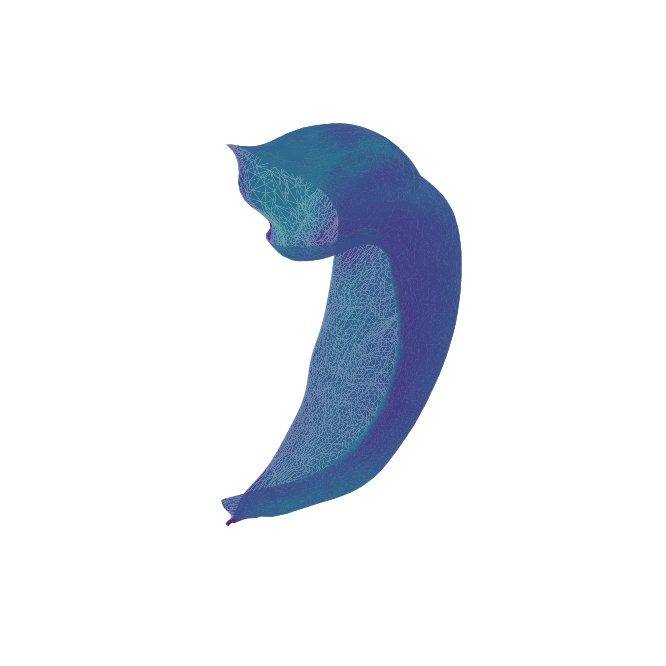

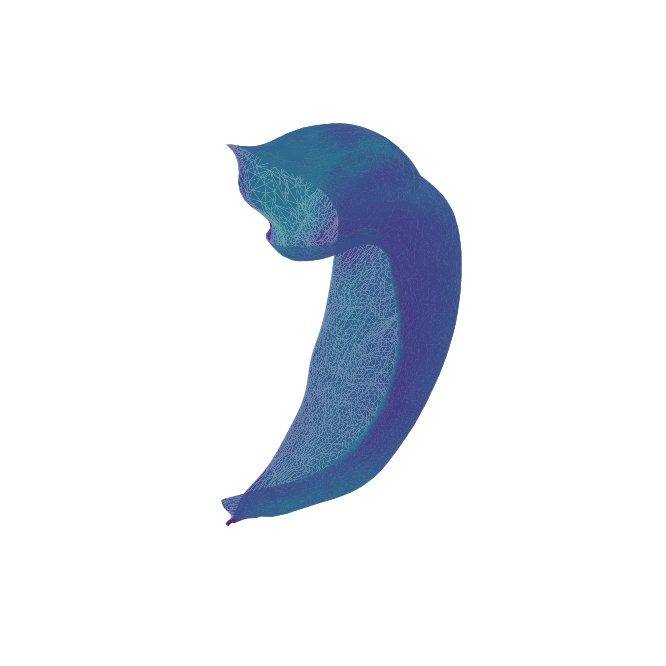

In [27]:
im_thickL = plt.imshow(thickL.mean(axis=0).reshape(1,thickL.shape[1]).T)
plt.close()
im_thickR = plt.imshow(thickR.mean(axis=0).reshape(1,thickL.shape[1]).T)
plt.close()
(fig1,ax1) = plot_gifti(avgsurf,thickL.mean(axis=0))

(fig2,ax2) = plot_gifti(avgsurf,thickR.mean(axis=0))


/tmp/ipykernel_522910/4017426698.py:69: UserWarning: Attempting to set identical bottom == top == 1.171875 results in singular transformations; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


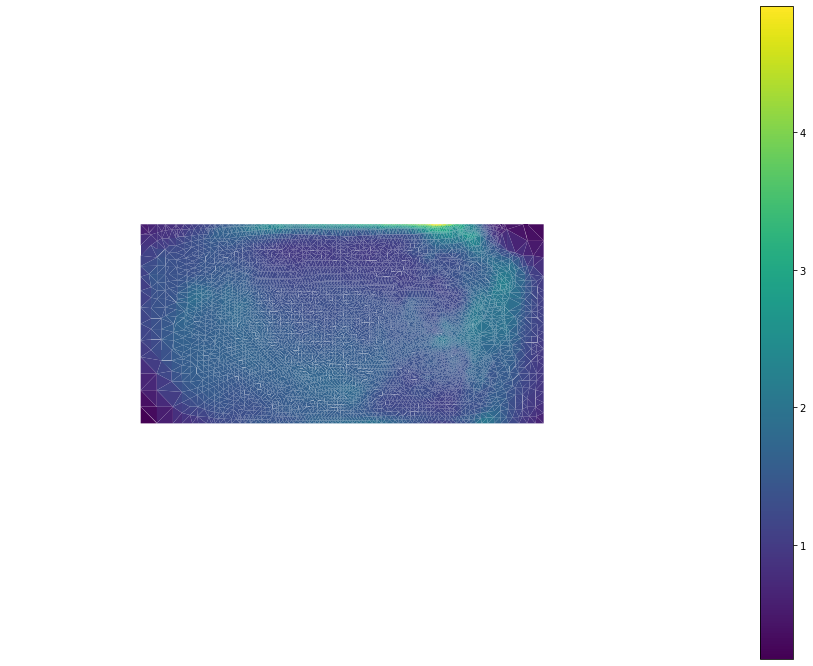

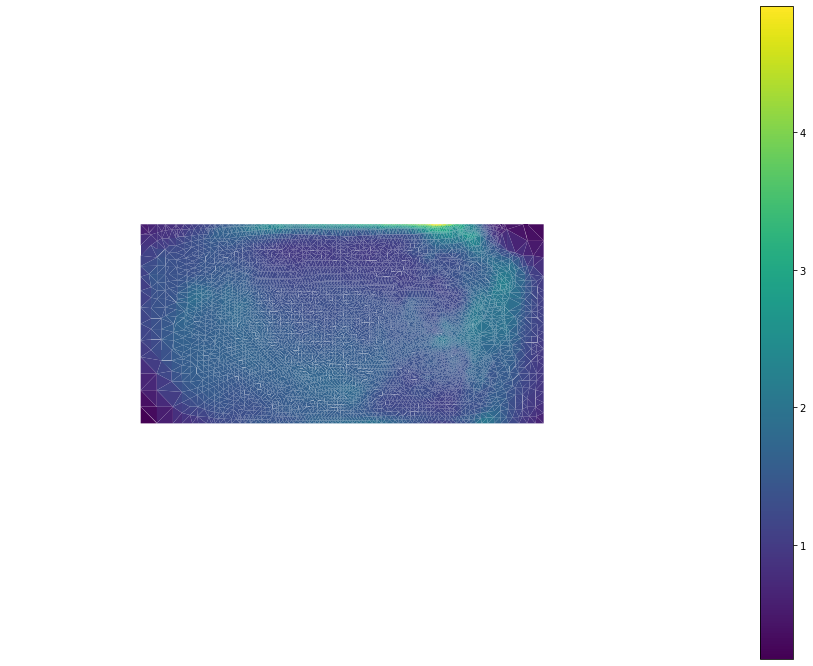

In [30]:
(fig,ax) = plot_gifti(flatmap_gii,thickL.mean(axis=0))
plt.colorbar(im_thickL,ax=ax)
(fig,ax) = plot_gifti(flatmap_gii,thickR.mean(axis=0))
plt.colorbar(im_thickR,ax=ax)

In [ ]:
thickL.shape

In [ ]:
im_thickL_std = plt.imshow(thickL.std(axis=0).reshape(1,thickL.shape[1]).T)
plt.close()
im_thickR_std = plt.imshow(thickR.std(axis=0).reshape(1,thickL.shape[1]).T)
plt.close()

plot_gifti(surfL,thickL.std(axis=0))
plt.colorbar(im_thickL_std)
plot_gifti(surfR,thickR.std(axis=0))
plt.colorbar(im_thickR_std)

In [ ]:
plot_gifti(flatmap_gii,thickL.std(axis=0))
plt.colorbar(im_thickL_std)
plot_gifti(flatmap_gii,thickR.std(axis=0))
plt.colorbar(im_thickR_std)

In [ ]:
df_hippunfold['Pre CA1-L']

In [ ]:


term_ca1_vol = FixedEffect(df_hippunfold['Pre CA1-R'])
term_sub_vol = FixedEffect(df_hippunfold['Pre Sub-L'])
term_avlt = FixedEffect(df_hippunfold['Pre-AVLTdelR'])


In [ ]:
mask = np.ones(thickL[0].shape)
mask= mask.astype(np.bool_)

#mask_LR = np.ones(thickness_data[0].shape)
#mask_LR= mask_LR.astype(np.bool_)

In [ ]:
model2 = term_ca1_vol

SLM2L = SLM(model2,
           df_hippunfold['Pre CA1-R'],
           flatmap,
           mask,
           correction=['fdr','rft'],
           cluster_threshold=0.01)
SLM2L.fit(thickL)

SLM2R = SLM(model2,
           df_hippunfold['Pre CA1-R'],
           flatmap,
           mask,
           correction=['fdr','rft'],
           cluster_threshold=0.01)
SLM2R.fit(thickR)

In [ ]:
plot_gifti(surfL, SLM2L.P['clusid'][0].T == 1,)


In [ ]:
plot_gifti(surfR, SLM2R.P['clusid'][0].T == 1,)


In [ ]:
model1 = term_avlt

SLM1L = SLM(model1,
           df_hippunfold['Pre-AVLTdelR'],
           flatmap,
           mask,
           correction=['fdr','rft'],
           cluster_threshold=0.01)
SLM1L.fit(thickL)

In [ ]:
SLM1R = SLM(model1,
           df_hippunfold['Pre-AVLTdelR'],
           flatmap,
           mask,
           correction=['fdr','rft'],
           cluster_threshold=0.01)
SLM1R.fit(thickR)

In [ ]:
#plot_gifti(surfL, SLM1L.t.T)
plot_gifti(surfL, SLM1L.P['clusid'][0].T == 1,)


In [ ]:
plot_gifti(surfR, SLM1R.P['clusid'][0].T == 1,)



In [ ]:
SLM1L.P['clus'][0].head()

In [ ]:
SLM1LR.P['clus'][1].head()

In [ ]:
SLM1LR.P['peak'][0].head()

In [ ]:
SLM1LR.P['peak'][1].head().head()

In [ ]:
max_dim = lambda array: np.argmax(np.shape(array))
split_hemi = lambda array, hemi: np.split(array,2,axis=max_dim(array))[0] if hemi.lower() == 'l' else np.split(array,2,axis=max_dim(array))[1]

In [ ]:
plot_gifti(surfL, split_hemi(SLM1L.P['clusid'][0].T == 1,'l'))
plot_gifti(surfR, split_hemi(SLM1LR.P['clusid'][0].T == 1,'r'))

In [ ]:
plot_gifti(flatmap_gii, split_hemi(SLM1LR.P['clusid'][0].T == 1,'l'))
plot_gifti(flatmap_gii, split_hemi(SLM1LR.P['clusid'][0].T == 2,'l'))

In [ ]:
plot_gifti(flatmap_gii, split_hemi(SLM1LR.P['clusid'][0].T == 2,'r'))
plot_gifti(flatmap_gii, split_hemi(SLM1LR.P['clusid'][0].T == 2,'r'))

In [ ]:
im_tstatLR_L = plt.imshow(split_hemi(SLM1LR.t.T,'l'),cmap='viridis');
plt.close()

im_tstatLR_R = plt.imshow(split_hemi(SLM1LR.t.T,'r'),cmap='viridis');
plt.close()

plot_gifti(flatmap_gii, split_hemi(SLM1LR.t.T,'l'))
plt.colorbar(mappable=im_tstatLR_L)

plot_gifti(flatmap_gii, split_hemi(SLM1LR.t.T,'r'))
plt.colorbar(mappable=im_tstatLR_R)

In [ ]:
model1 = term_age + term_sex + term_group + term_glucose
SLM1L = SLM(model1,
           df_hippunfold.Glucose_t0,
           flatmap,
           mask,
           correction=['fdr','rft'],
           cluster_threshold=0.01)
SLM1L.fit(np.apply_along_axis(gaussian_filter,axis=1,arr=thickL,sigma=3))

In [ ]:
SLM1L.P['clus'][0].head()

In [ ]:
plot_gifti(surfL, SLM1L.P['clusid'][0].T == 1)
plot_gifti(surfL, SLM1L.P['clusid'][0].T == 2)

In [ ]:
plot_gifti(flatmap_gii, SLM1L.P['clusid'][0].T == 1)
plot_gifti(flatmap_gii, SLM1L.P['clusid'][0].T == 2)

In [ ]:
im_tstatL = plt.imshow(SLM1L.t.T,cmap='viridis');
plt.close()
plot_gifti(flatmap_gii, SLM1L.t.T)
plt.colorbar(mappable=im_tstatL)

In [ ]:
plot_gifti(surfL, SLM1L.t.T)
plt.colorbar(mappable=im_tstatL)

In [ ]:
SLM1R = SLM(model1,
           df_hippunfold.Glucose_t0,
           flatmap,
           mask,
           correction=['fdr','rft'],
           cluster_threshold=0.01)
SLM1R.fit(np.apply_along_axis(gaussian_filter,axis=1,arr=thickR,sigma=3))

In [ ]:
SLM1R.P['clus'][0].head()

In [ ]:
plot_gifti(surfR, SLM1R.P['clusid'][0].T == 1)
plot_gifti(surfR, SLM1R.P['clusid'][0].T == 2)

In [ ]:
plot_gifti(flatmap_gii, SLM1R.P['clusid'][0].T == 1)
plot_gifti(flatmap_gii, SLM1R.P['clusid'][0].T == 2)

In [ ]:
im_tstatR = plt.imshow(SLM1R.t.T,cmap='viridis');
plt.close()
plot_gifti(flatmap_gii, SLM1R.t.T)
plt.colorbar(mappable=im_tstatR)

In [ ]:
plot_gifti(surfR, SLM1R.t.T)
plt.colorbar(mappable=im_tstatR)

In [ ]:
bigbrain_pathR = dm2_hippunfold.path_wildcards('surf')[2].format(subject='S01',hemi='R',label='hipp')
bigbrain_pathL = dm2_hippunfold.path_wildcards('surf')[2].format(subject='S01',hemi='L',label='hipp')

In [ ]:
bigbrainR = nib.load(bigbrain_pathR).darrays[0].data
bigbrainL = nib.load(bigbrain_pathL).darrays[0].data

In [ ]:
bigbrain = np.concatenate([bigbrainL,bigbrainR])

In [ ]:
thickness_bigbrain = reduce_by_labels(thickness_data,bigbrain.T)

In [ ]:
thickness_bigbrain_df = pd.DataFrame(thickness_bigbrain,index=dm2_hippunfold.subjects).reset_index()

In [ ]:
thickness_bigbrain_df.head()

In [ ]:
thickness_bigbrain_df.columns = ['STUDY_ID',0,1,2,3,4]

In [ ]:
label_map_dict = dict(zip(df_hippunfold.GROUP.unique(),[0,1,2]))
groups_numerical = df_hippunfold.GROUP.map(label_map_dict)

In [ ]:
thickness_bigbrain_df = pd.merge(df_hippunfold[['STUDY_ID','GROUP']],thickness_bigbrain_df)

In [ ]:
thickness_bigbrain_df_melt = pd.melt(thickness_bigbrain_df,id_vars=['STUDY_ID','GROUP'])
thickness_bigbrain_df_melt.columns = ['STUDY_ID','GROUP','SUBFIELDS','THICKNESS']

In [ ]:
thickness_bigbrain_df_melt

In [ ]:
sns.boxplot(x='SUBFIELDS',y='THICKNESS', data = thickness_bigbrain_df_melt, hue ='GROUP')
plt.xticks(ticks=[0,1,2,3,4],labels=['Subiculum','CA1','CA2','CA3','CA4'])
plt.show()

In [ ]:
sns.violinplot(x='SUBFIELDS',y='THICKNESS', data = thickness_bigbrain_df_melt, hue ='GROUP')

In [ ]:
sns.boxplot(data = thickness_bigbrain_df)